In [88]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

import numpy.random as npr
import matplotlib.cm as mpcm
import healpy as hp
import classy
    
%matplotlib inline

In [89]:
# functions
def a_lm_r2c(a_lm_r):

    """Convert real a_lm array (at given lm) to complex."""
    n_fields, n_a_lm_r = a_lm_r.shape
    el = (n_a_lm_r - 1) / 2
    a_lm_c = np.zeros((n_fields, el + 1), 'complex')
    a_lm_c[:, 0] = a_lm_r[:, el] + 0.0j
    for m in range(1, el + 1):
        a_lm_c[:, m] = a_lm_r[:, el + m] / np.sqrt(2.0) - \
                       a_lm_r[:, el - m] / np.sqrt(2.0) * 1.0j
    return a_lm_c

def pars_to_cls(l_min, l_max, n_fields, cosmo, pars):
    
    # generate CLASS cosmology
    class_params = {
        'T_cmb': 2.7255,
        'omega_b': 0.02227,
        'n_s': 0.9681,
        'N_ur': 3.046,
        'Omega_dcdmdr': 0.0,
        'Gamma_dcdm': 0.0,
        'N_ncdm': 0,
        'Omega_k': 0.,
        'Omega_fld': 0,
        'Omega_scf': 0,
        'YHe': 'BBN',
        'recombination': 'RECFAST',
        'reio_parametrization': 'reio_camb',
        'tau_reio': 0.067,
        'reionization_exponent': 1.5,
        'reionization_width': 0.5,
        'helium_fullreio_redshift': 3.5,
        'helium_fullreio_width': 0.5,
        'annihilation': 0.,
        'decay': 0.,
        'output': 'tCl pCl lCl nCl',
        'modes': 's',
        'lensing': 'yes',
        'ic': 'ad',
        'gauge': 'synchronous',
        'P_k_ini type': 'analytic_Pk',
        'k_pivot': 0.05,
        'alpha_s': 0.,
        'l_max_scalars': 2500,
        'l_max_lss': 300,
        'selection': 'tophat',
        'selection_mean': '0.3, 0.5, 0.7, 0.9, 1.1',
        'selection_width': 0.2,
        'non_diagonal': 4,
    }
    class_params['A_s'], class_params['omega_cdm'], class_params['h'] = pars[1:]
    cosmo.set(class_params)
    cosmo.compute()
    lensed_c_l = cosmo.lensed_cl()
    density_c_l = cosmo.density_cl()
    
    # process CLASS power spectra to form constituents of
    # required covariance matrix. CLASS phi-phi C_ls are in 
    # cosmo.lensed_cl()['pp']; phi-galaxy cross C_ls are in 
    # cosmo.density_cl()['pd'][0]...[n_gal_fields-1] (using CLASS 
    # pull request 224); galaxy-galaxy C_ls are in 
    # cosmo.density_cl()['pd'][i] where i is as below:
    #  0:dens[1]-dens[1], 1:dens[1]-dens[2], 2:dens[1]-dens[3],
    #  3:dens[1]-dens[4], 4:dens[1]-dens[5], 5:dens[2]-dens[2], 
    #  6:dens[2]-dens[3], 7:dens[2]-dens[4], 8:dens[2]-dens[5],
    #  9:dens[3]-dens[3], 10:dens[3]-dens[4], 11:dens[3]-dens[5],
    #  12:dens[4]-dens[4], 13:dens[4]-dens[5], 14:dens[5]-dens[5]
    # we want to reorder into an upper triangle. data structure
    # based n_comp-length units of g_lm^1, ..., g_lm^n, k_lm.
    # covariance matrix is then n_comp x n_comp:
    #   C_l^{g_1 g_1} ... C_l^{g_1 g_n} C_l^{g_1 k}
    #   .
    #   .
    #   .
    #   C_l^{g_n g_1} ... C_l^{g_n g_n} C_l^{g_n k}
    #   C_l^{k g_1}   ... C_l^{k g_n}   C_l^{k k}
    # NB: apply bias (pars[0]) here to gal-gal and gal-phi spectra
    n_combs = n_fields * (n_fields + 1) / 2
    n_l = l_max - l_min + 1
    l_min_class = 0
    i_l_min = l_min - l_min_class
    i_l_max = l_max + l_min_class + 1
    c_l = np.zeros((n_l, n_combs))
    j = 0
    for i in range(0, n_fields - 1):
        n_j = n_fields - i
        for k in range(j, j + n_j - 1):
            c_l[:, k] = density_c_l['dd'][k - i][i_l_min: i_l_max] * pars[0] ** 2           # gal-gal
        c_l[:, j + n_j - 1] = density_c_l['pd'][n_fields - n_j][i_l_min: i_l_max] * pars[0] # phi-gal
        j += n_j
    c_l[:, -1] = lensed_c_l['pp'][i_l_min: i_l_max]                                         # phi-phi
    
    # tidy up and return
    cosmo.struct_cleanup()
    return c_l

def dc_l_dpar(l_min, l_max, n_fields, cosmo, c_l_fid, pars_fid, delta, rescaled_a_s=False):
    
    # setup
    n_l = l_max - l_min + 1
    n_combs = n_fields * (n_fields + 1) / 2
    n_pars = len(pars_fid)
    dcldpar = np.zeros((n_l, n_combs, n_pars))
    
    # calculate derivatives. derivatives wrt bias and a_s (first two parameters)
    # are analytic
    j = 0
    for i in range(0, n_fields - 1):
        n_j = n_fields - i
        for k in range(j, j + n_j - 1):
            dcldpar[:, k, 0] = 2.0 * c_l_fid[:, k] / pars_fid[0]           # gal-gal
        dcldpar[:, j + n_j - 1, 0] = c_l_fid[:, j + n_j - 1] / pars_fid[0] # phi-gal
        j += n_j
    if rescaled_a_s:
        dcldpar[:, :, 1] = c_l_fid[:, :] * np.log(10.0)
    else:
        dcldpar[:, :, 1] = c_l_fid[:, :] / pars_fid[1]
    
    # rest are numerical
    for i in range(2, n_pars):
        idx = np.zeros(n_pars)
        idx[i] = 1.0
        print pars_fid + delta * idx
        print pars_fid - delta * idx
        c_l_plus = pars_to_cls(l_min, l_max, n_fields, cosmo, pars_fid + delta * idx)
        c_l_minus = pars_to_cls(l_min, l_max, n_fields, cosmo, pars_fid - delta * idx)
        dcldpar[:, :, i] = (c_l_plus - c_l_minus) / (2.0 * delta[i])
        if i == n_pars - 1:
            print c_l_plus[0, -1]
            print c_l_minus[0, -1]
    
    return dcldpar

def fisher_matrix(l_min, l_max, n_fields, c_l_fid, dc_l_dpar_fid, n_l_gg, n_l_pp):
    
    n_l = l_max - l_min + 1
    ell = np.arange(l_min, l_max + 1, dtype=float)
    n_pars = dc_l_dpar_fid.shape[-1]
    cov = np.zeros((n_fields, n_fields))
    cov_der = np.zeros((n_fields, n_fields, n_pars))
    f_mat = np.zeros((n_pars, n_pars))
    sc_mat_1 = np.zeros(n_pars)
    sc_mat_2 = np.zeros((n_fields, n_fields, n_pars, n_l))
    for i in range(0, n_l):

        # construct n_field x n_field covariance matrix. need to convert
        # from upper triangle to lower for Cholesky. do same for derivatives
        k = 0
        for j in range(0, n_fields):
            n_k = n_fields - j
            cov[j:, j] = c_l_fid[i, k: k + n_k]
            cov[j, j:] = cov[j:, j]
            cov_der[j:, j, :] = dc_l_dpar_fid[i, k: k + n_k, :]
            cov_der[j, j:, :] = cov_der[j:, j, :]
            k += n_k

        # add harmonic-diagonal noise diagonal covariance entries
        for j in range(0, n_fields - 1):
            cov[j, j] += n_l_gg[i]
        cov[-1, -1] += n_l_pp[i]

        # invert covariance and form Fisher matrix
        cov_inv = np.linalg.inv(cov)
        cicd = np.einsum('ij,jkl', cov_inv, cov_der)
        f_mat += (2.0 * ell[i] + 1.0) * np.einsum('ijk,jil', cicd, cicd)

        # compute components of score compression
        sc_mat_1 -= (2.0 * ell[i] + 1.0) / 2.0 * np.einsum('iij', cicd)
        sc_mat_2[..., i] = np.einsum('ijl,jk', cicd, cov_inv)
    
    return np.linalg.inv(f_mat), sc_mat_1, sc_mat_2

def compressed_sim(pars, args):
    
    # parse settings and generate C_ls
    n_pars = len(pars)
    l_min, l_max, n_fields, cosmo, pars_fid, f_mat_inv, c_l_fid, \
        n_l_gg, n_l_pp, sc_mat_1, sc_mat_2 = args
    n_l = l_max - l_min + 1
    ell = np.arange(l_min, l_max + 1, dtype=float)
    c_l = pars_to_cls(l_min, l_max, n_fields, cosmo, pars)
    
    # generate compressed sim
    cov = np.zeros((n_fields, n_fields))
    d_comp = np.zeros(n_pars)
    d_comp += sc_mat_1
    for i in range(0, n_l):

        # construct n_field x n_field covariance matrix. need to convert
        # from upper triangle to lower for Cholesky
        k = 0
        for j in range(0, n_fields):
            n_k = n_fields - j
            cov[j:, j] = c_l[i, k: k + n_k]
            cov[j, j:] = cov[j:, j]
            k += n_k

        # add harmonic-diagonal noise diagonal covariance entries
        for j in range(0, n_fields - 1):
            cov[j, j] += n_l_gg[i]
        cov[-1, -1] += n_l_pp[i]

        # generate 2l+1 real a_lms and calculate 
        # observed covariance for score compression
        el = l_min + i
        ems = np.arange(el + 1)
        cov_chol = np.linalg.cholesky(cov)
        a_lm_r = np.dot(cov_chol, npr.randn(n_fields, 2 * el + 1))
        cov_obs = np.cov(a_lm_r)
        
        # compress!
        cicdcico = np.einsum('ijl,jk', sc_mat_2[..., i], cov_obs)
        d_comp += (2.0 * ell[i] + 1.0) / 2.0 * np.einsum('iij', cicdcico)

    return pars_fid + np.dot(f_mat_inv, d_comp)

In [90]:
# settings
rescaled_a_s = True
n_z_bins = 5
n_fields = n_z_bins + 1
l_min = 8 # set by Planck N_l^kk
l_max = 64#1000
n_l = l_max - l_min + 1
n_a_lm_c = (l_max + 1) * (l_max + 2) / 2
n_side = 32#512
n_pix = hp.nside2npix(n_side)
use_mask = None # None, 'des_sv' or 'des_sv_planck' 
mask_noise = 1e20
constrain = True
if constrain:
    npr.seed(20141023)

# fiducial cosmology
cosmo = classy.Class()
bias = 1.15
a_s = 2.143e-9
omega_c = 0.1184
h = 0.6790
theta_fiducial = np.array([bias, a_s, omega_c, h])
if rescaled_a_s:
    theta_fiducial[1] = np.log10(1.0e10 * theta_fiducial[1])
delta_theta = theta_fiducial * np.array([0.0, 0.0, 0.05, 0.05])
c_l_fid = pars_to_cls(l_min, l_max, n_fields, cosmo, theta_fiducial)
dc_l_dpar_fid = dc_l_dpar(l_min, l_max, n_fields, cosmo, c_l_fid, \
                          theta_fiducial, delta_theta, rescaled_a_s=rescaled_a_s)

# plotting settings
lw = 1.5
plt.rc('font', family = 'serif')
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['lines.linewidth'] = lw
cm = mpcm.get_cmap('plasma')
cols = [cm(i / float(n_fields)) for i in range(n_fields)]

[1.150e+00 2.143e-09 1.184e-01 6.790e-01]
[1.15       1.33102217 0.1184     0.679     ]
[1.15       1.33102217 0.12432    0.679     ]
[1.15       1.33102217 0.11248    0.679     ]
[1.15       1.33102217 0.1184     0.71295   ]
[1.15       1.33102217 0.1184     0.64505   ]
0.07323630883785533
0.07689765537238483


In [96]:
# read in approximate mask if desired
if use_mask is not None:

    # DES SV mask is high resolution: needs degrading and restricting
    # to SPT patch to match their analysis.apply this mask to all 
    # galaxy fields
    print '= processing mask(s) ='
    masks = np.array(n_fields, n_pix)
    mask_file = 'inputs/sva1_gold_r1.0_goodregions_04_n4096.fits.gz'
    mask_in = hp.read_map(mask_file)
    n_pix_mask = mask_in.shape[0]
    n_side_mask = hp.npix2nside(n_pix_mask)
    inds = np.arange(n_pix_mask, dtype = int)
    theta, phi = hp.pix2ang(n_side_mask, inds)
    mask_in[phi < 50.0 * np.pi / 180.0] = 0
    mask_in[phi > 95.0 * np.pi / 180.0] = 0
    mask_in[theta < 130.0 * np.pi / 180.0] = 0
    mask = hp.ud_grade(mask_in, nside_out = n_side, \
                       order_in = 'RING', order_out = 'RING')
    mask[mask >= 0.5] = 1.0
    mask[mask < 0.5] = 0.0
    for i in range(n_fields - 1):
        masks[i, :] = mask

    # optionally apply Planck lensing mask to CMB lensing
    if use_mask == 'des_sv_planck':
        mask_file = 'inputs/planck_2015_lensing_mask.fits.gz'
        mask_in = hp.read_map(mask_file)
        mask = hp.ud_grade(mask_in, nside_out = n_side, \
                           order_in = 'RING', order_out = 'RING')
        mask[mask >= 0.5] = 1.0
        mask[mask < 0.5] = 0.0
    masks[-1, :] = mask

    # @TODO: there is another option here: to multiply the two masks.
    #        this is what the DES-SPT did, but it's wasteful

    #f_sky = 131.0 * (np.pi / 180.0) ** 2 / (4.0 * np.pi)

else:
    mask = np.ones((n_fields, n_pix))

# @TODO: update this to account for multiple masks
f_sky = np.sum(mask[0, :]) / n_pix
null_mask = (1.0 - mask) * hp.UNSEEN
print 'f_sky = {:5.3f}'.format(f_sky)

# generate lensing and galaxy noise and plot. Planck lensing noise is
# in k not phi, so convert. we want pixel-diagonal noise fo galaxies,
# so generate a set of pixel variances scattered around expected 
# value (set by number of galaxies in each bin)
print '= characterizing noise ='
l_min_pla = 8
l_max_pla = 2048
if (l_min < l_min_pla):
    exit('Please pick l_min >= 8!')
if (l_max > l_max_pla):
    exit('Please pick l_max <= 2048!')
i_l_min = l_min - l_min_pla
i_l_max = l_min - l_min_pla + n_l
n_l_pp_pla = np.genfromtxt('inputs/nlkk.dat')
n_l_pp = 4.0 * n_l_pp_pla[i_l_min: i_l_max, 1] / \
         (n_l_pp_pla[i_l_min: i_l_max, 0] * \
          (n_l_pp_pla[i_l_min: i_l_max, 0] + 1.0)) ** 2
gal_density = 5.39 * (60.0 * 180.0 / np.pi) ** 2 # gal per sterad
omega_p = 4.0 * np.pi / n_pix
mean_var_n_p = n_z_bins / gal_density / omega_p
#var_n_p = (1.0 + 0.1 * npr.randn(n_fields - 1, n_pix)) * mean_var_n_p
var_n_p = np.ones((n_fields - 1, n_pix)) * mean_var_n_p
if use_mask:
    var_n_p[:, mask == 0.0] = mask_noise
n_p_gg = npr.randn(n_fields - 1, n_pix) * np.sqrt(var_n_p)
n_l_gg = mean_var_n_p * omega_p * np.ones(n_l) # for Fisher estimate

f_sky = 1.000
= characterizing noise =


In [118]:
# LFI setup

# priors
prior_mean = theta_fiducial
if rescaled_a_s:
    lower = np.array([0.0, 0.0, 0.0, 0.5])
    upper = np.array([2.0, 2.0, 1.0, 0.9])
    prior_sigmas = np.array([0.1, 0.1, 0.03, 0.1])
else:
    lower = np.array([0.0, 0.0, 0.0, 0.5])
    upper = np.array([2.0, 1.0e-8, 1.0, 0.9])
    prior_sigmas = np.array([0.1, 1.0e-9, 0.03, 0.1])
prior_cov = np.eye(len(theta_fiducial)) * prior_sigmas ** 2
prior_args = [prior_mean, prior_cov, lower, upper]

# getdist settings
names = ['bias', 'a_s', 'omega_c', 'h']
labels =  [r'b', r'A_{\rm s}', r'\Omega_c', r'h']
ranges = {'bias':[lower[0], upper[0]], 'a_s':[lower[1], upper[1]], \
          'omega_c':[lower[2], upper[2]], 'h':[lower[3], upper[3]]}

# inverse fisher matrix and inputs for compressed simulations
f_mat_inv, sc_mat_1, sc_mat_2 = fisher_matrix(l_min, l_max, n_fields, c_l_fid, dc_l_dpar_fid, n_l_gg, n_l_pp)
sim_args = [l_min, l_max, n_fields, cosmo, theta_fiducial, f_mat_inv, \
            c_l_fid, n_l_gg, n_l_pp, sc_mat_1, sc_mat_2]

In [119]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: compressed_sim(x, sim_args)

In [120]:
# The data vector: import or otherwise simulate for testing
data = compressed_sim(theta_fiducial, sim_args)
str_out = ''
for i in range(0, len(theta_fiducial)):
    for j in range(0, i):
        str_out += '{:10.3e} '.format(f_mat_inv[i, j] / np.sqrt(f_mat_inv[i, i] * f_mat_inv[j, j]))
    str_out += '{:10.3e}'.format(np.sqrt(f_mat_inv[i, i]))
    if i < len(theta_fiducial) - 1:
        str_out += '\n'
print 'Fisher: sigmas on diagonal, correlation coefficients off diagonal'
print str_out
print 'Fid params: ', theta_fiducial
print 'Realisation:', data

Fisher: sigmas on diagonal, correlation coefficients off diagonal
 1.897e-02
 3.704e-02  6.777e-03
-7.258e-01 -5.621e-01  3.148e-03
-9.087e-01 -4.065e-01  8.671e-01  1.816e-02
Fid params:  [1.15       1.33102217 0.1184     0.679     ]
Realisation: [1.15148784 1.33405935 0.1166762  0.67521427]


In [121]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, prior_cov, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, f_mat_inv, lower, upper)

In [122]:
# Create the DELFI MDN object
n_components = 1

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, f_mat_inv, \
                                     theta_fiducial, data, n_components, n_hidden = [50, 50], \
                                     activations = ['tanh', 'tanh'], names = names, \
                                     labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 45s 1ms/step - loss: 29.2346 - val_loss: 11.2861
Epoch 2/10
45000/45000 [==============================] - 43s 966us/step - loss: 10.4789 - val_loss: 9.7077
Epoch 3/10
45000/45000 [==============================] - 47s 1ms/step - loss: 9.1588 - val_loss: 8.5424
Epoch 4/10
45000/45000 [==============================] - 38s 853us/step - loss: 7.7975 - val_loss: 7.0019
Epoch 5/10
45000/45000 [==============================] - 44s 987us/step - loss: 6.3410 - val_loss: 5.7204
Epoch 6/10
45000/45000 [==============================] - 43s 957us/step - loss: 5.3299 - val_loss: 4.8999
Epoch 7/10
45000/45000 [==============================] - 39s 867us/step - loss: 4.7707 - val_loss: 4.5470
Epoch 8/10
45000/45000 [==============================] - 41s 907us/step - loss: 4.4632 - val_loss: 4.2736
Epoch 9/10
45000/45000 [==============================] - 3

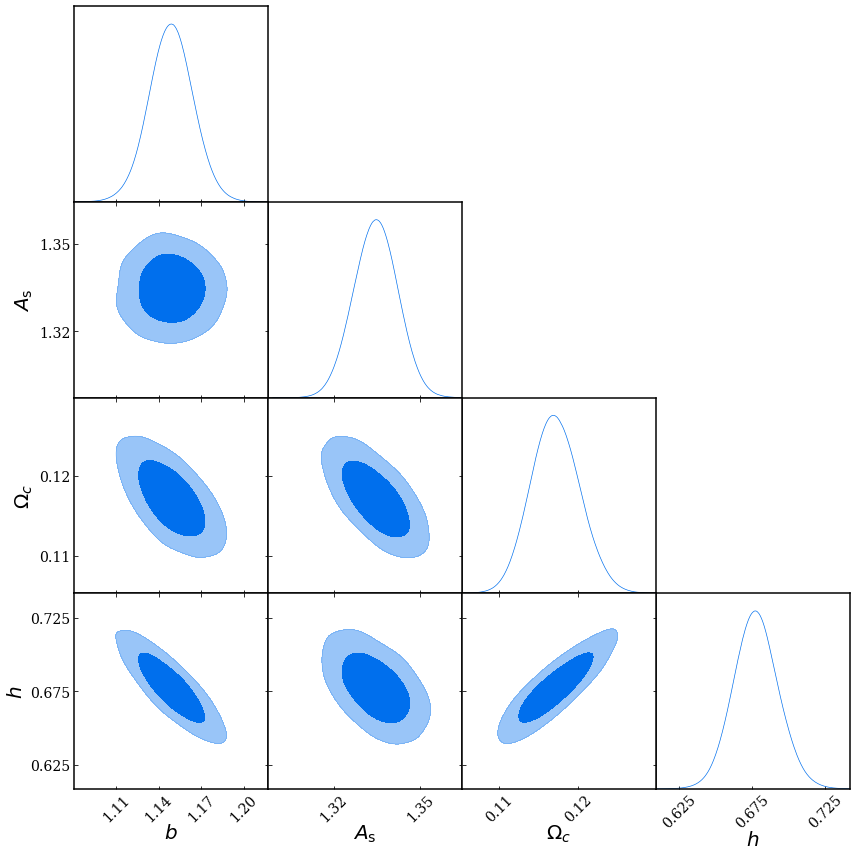

In [123]:
# Do the Fisher pre-training
#mdn.fisher_pretraining(50000, prior, epochs=50)
#mdn.fisher_pretraining(50000, prior, epochs=25)
mdn.fisher_pretraining(50000, prior, epochs=10)

Running initial 50 sims...
Done.
Train on 45 samples, validate on 5 samples
Epoch 1/100
45/45 [==============================] - 0s 821us/step - loss: 10.1247 - val_loss: 8.5178
Epoch 2/100
45/45 [==============================] - 0s 768us/step - loss: 8.5459 - val_loss: 7.3308
Epoch 3/100
45/45 [==============================] - 0s 811us/step - loss: 7.1232 - val_loss: 7.9073
Epoch 4/100
45/45 [==============================] - 0s 835us/step - loss: 6.4657 - val_loss: 8.5110
Epoch 5/100
45/45 [==============================] - 0s 761us/step - loss: 6.2005 - val_loss: 8.5292
Epoch 6/100
45/45 [==============================] - 0s 921us/step - loss: 6.1901 - val_loss: 8.1737
Epoch 7/100
45/45 [==============================] - 0s 926us/step - loss: 6.1271 - val_loss: 7.3338
Epoch 8/100
45/45 [==============================] - 0s 907us/step - loss: 5.6926 - val_loss: 6.3961
Epoch 9/100
45/45 [==============================] - 0s 1ms/step - loss: 5.2071 - val_loss: 5.7065
Epoch 10/100
45/

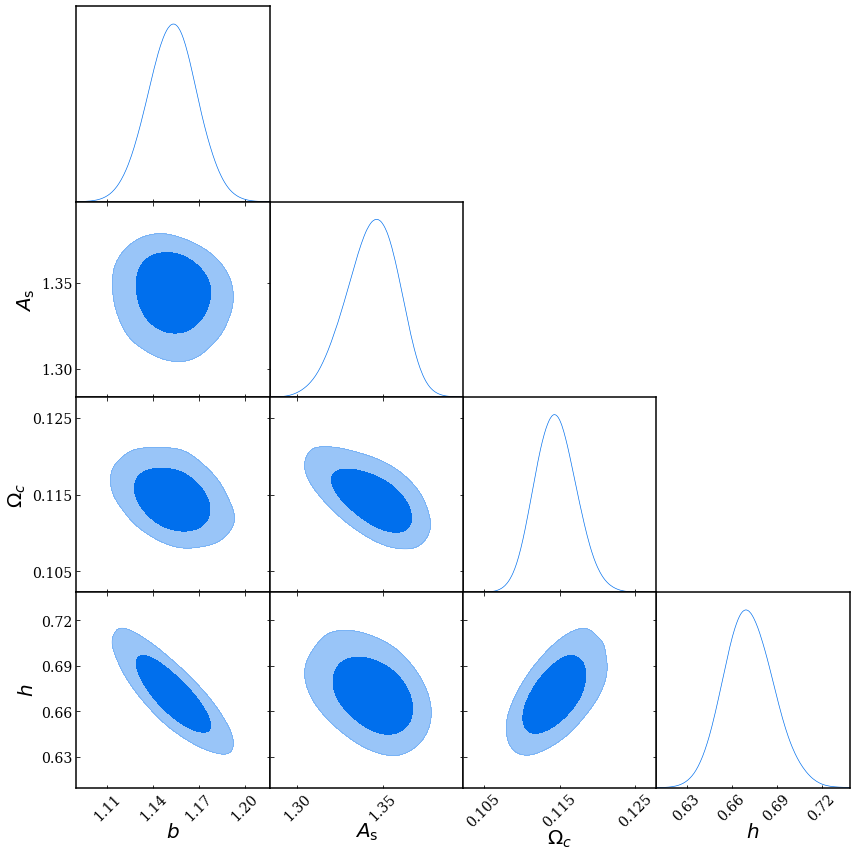

Population 1/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 90 samples, validate on 10 samples
Epoch 1/100
90/90 [==============================] - 0s 727us/step - loss: 3.0090 - val_loss: 3.2380
Epoch 2/100
90/90 [==============================] - 0s 707us/step - loss: 2.6392 - val_loss: 2.8889
Epoch 3/100
90/90 [==============================] - 0s 699us/step - loss: 2.5034 - val_loss: 2.7151
Epoch 4/100
90/90 [==============================] - 0s 797us/step - loss: 2.3562 - val_loss: 2.6044
Epoch 5/100
90/90 [==============================] - 0s 712us/step - loss: 2.2139 - val_loss: 2.5482
Epoch 6/100
90/90 [==============================] - 0s 752us/step - loss: 2.1398 - val_loss: 2.4704
Epoch 7/100
90/90 [==============================] - 0s 731us/step - loss: 2.0834 - val_loss: 2.4490
Epoch 8/100
90/90 [==============================] - 0s 709us/step - loss: 2.1196 - val_loss: 2.4367
Epoch 9/100
90/90 [==============================] - 0s 761us/step - loss

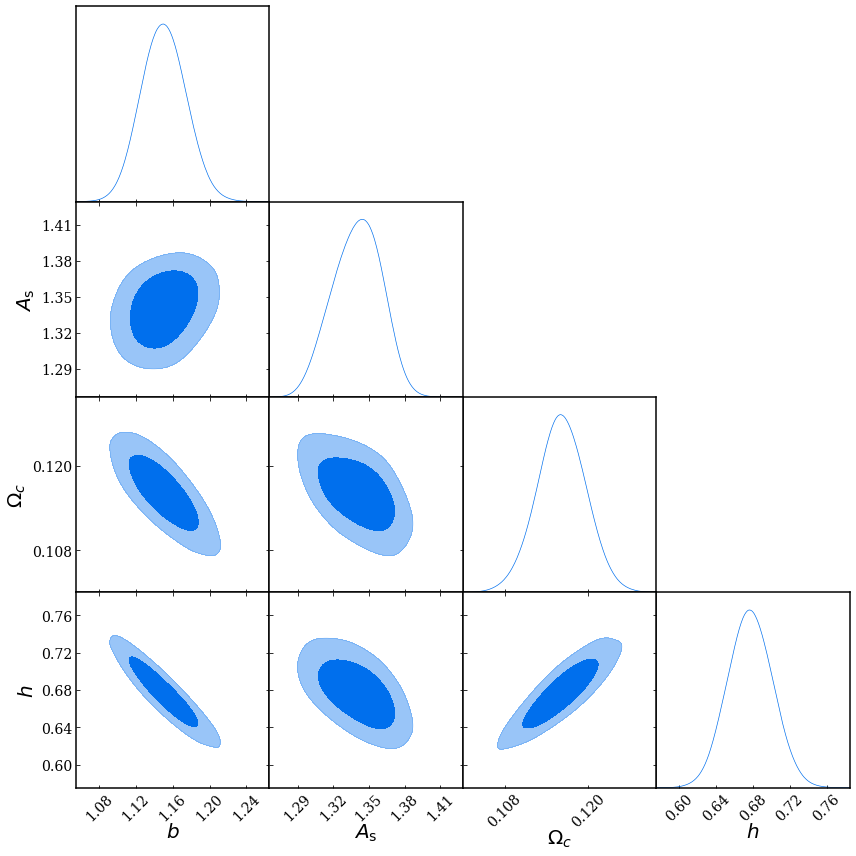

Population 2/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 135 samples, validate on 15 samples
Epoch 1/100
135/135 [==============================] - 0s 763us/step - loss: 1.7730 - val_loss: 1.6214
Epoch 2/100
135/135 [==============================] - 0s 790us/step - loss: 1.7651 - val_loss: 1.6507
Epoch 3/100
135/135 [==============================] - 0s 771us/step - loss: 1.7978 - val_loss: 1.5206
Epoch 4/100
135/135 [==============================] - 0s 782us/step - loss: 1.7441 - val_loss: 1.5286
Epoch 5/100
135/135 [==============================] - 0s 788us/step - loss: 1.7232 - val_loss: 1.5966
Epoch 6/100
135/135 [==============================] - 0s 793us/step - loss: 1.7257 - val_loss: 1.5417
Epoch 7/100
135/135 [==============================] - 0s 812us/step - loss: 1.7247 - val_loss: 1.5592
Epoch 8/100
135/135 [==============================] - 0s 1ms/step - loss: 1.7117 - val_loss: 1.5558
Epoch 9/100
135/135 [==============================] - 0s 

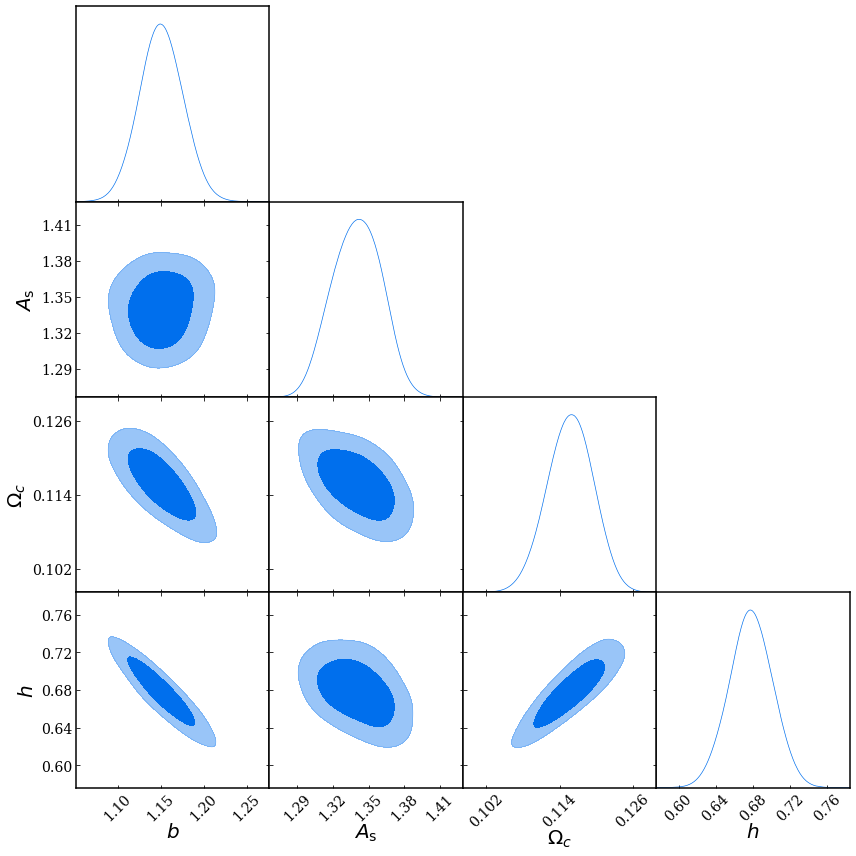

Population 3/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 180 samples, validate on 20 samples
Epoch 1/100
180/180 [==============================] - 0s 1ms/step - loss: 1.7299 - val_loss: 1.6113
Epoch 2/100
180/180 [==============================] - 0s 1ms/step - loss: 1.7244 - val_loss: 1.5082
Epoch 3/100
180/180 [==============================] - 0s 940us/step - loss: 1.7088 - val_loss: 1.4095
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 1.7109 - val_loss: 1.4645
Epoch 5/100
180/180 [==============================] - 0s 988us/step - loss: 1.6679 - val_loss: 1.4869
Epoch 6/100
180/180 [==============================] - 0s 814us/step - loss: 1.6806 - val_loss: 1.5112
Epoch 7/100
180/180 [==============================] - 0s 802us/step - loss: 1.6520 - val_loss: 1.3608
Epoch 8/100
180/180 [==============================] - 0s 860us/step - loss: 1.6583 - val_loss: 1.4474
Epoch 9/100
180/180 [==============================] - 0s 1ms/

Sampling approximate posterior...
Done.


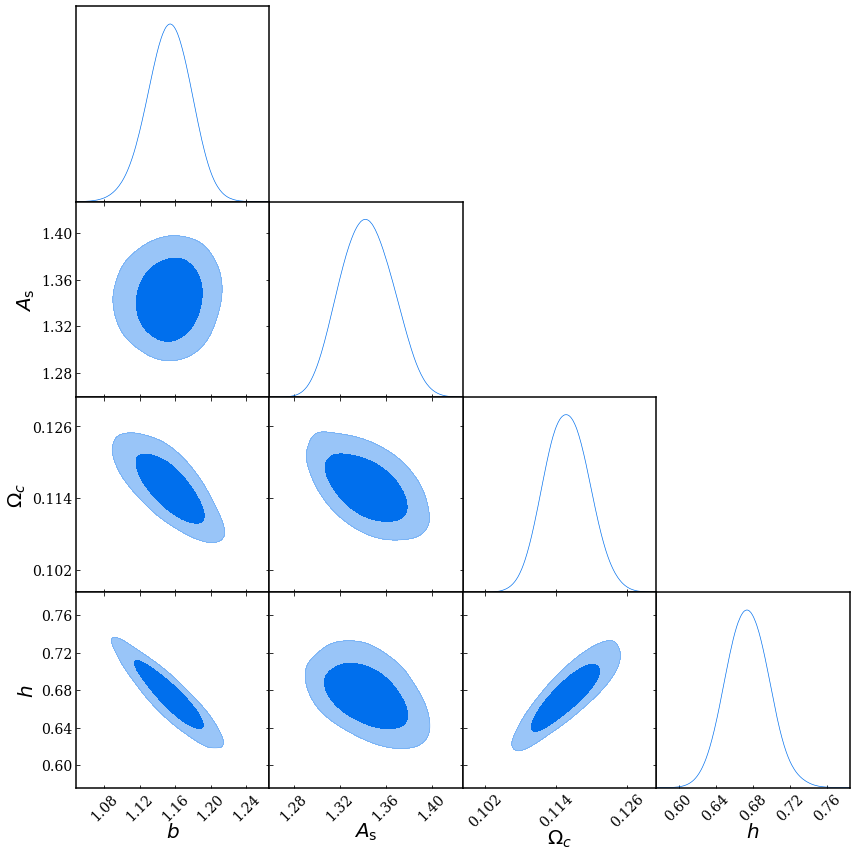

Population 4/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 225 samples, validate on 25 samples
Epoch 1/100
225/225 [==============================] - 0s 1ms/step - loss: 1.7153 - val_loss: 6.7887
Epoch 2/100
225/225 [==============================] - 0s 1ms/step - loss: 1.8941 - val_loss: 3.4103
Epoch 3/100
225/225 [==============================] - 0s 1ms/step - loss: 1.8852 - val_loss: 3.1107
Epoch 4/100
225/225 [==============================] - 0s 1ms/step - loss: 1.6849 - val_loss: 3.6192
Epoch 5/100
225/225 [==============================] - 0s 1ms/step - loss: 1.6444 - val_loss: 3.9655
Epoch 6/100
225/225 [==============================] - 0s 1ms/step - loss: 1.6370 - val_loss: 2.1140
Epoch 7/100
225/225 [==============================] - 0s 1ms/step - loss: 1.6427 - val_loss: 4.6386
Epoch 8/100
225/225 [==============================] - 0s 1ms/step - loss: 1.7724 - val_loss: 2.8981
Epoch 9/100
225/225 [==============================] - 0s 1ms/step - los

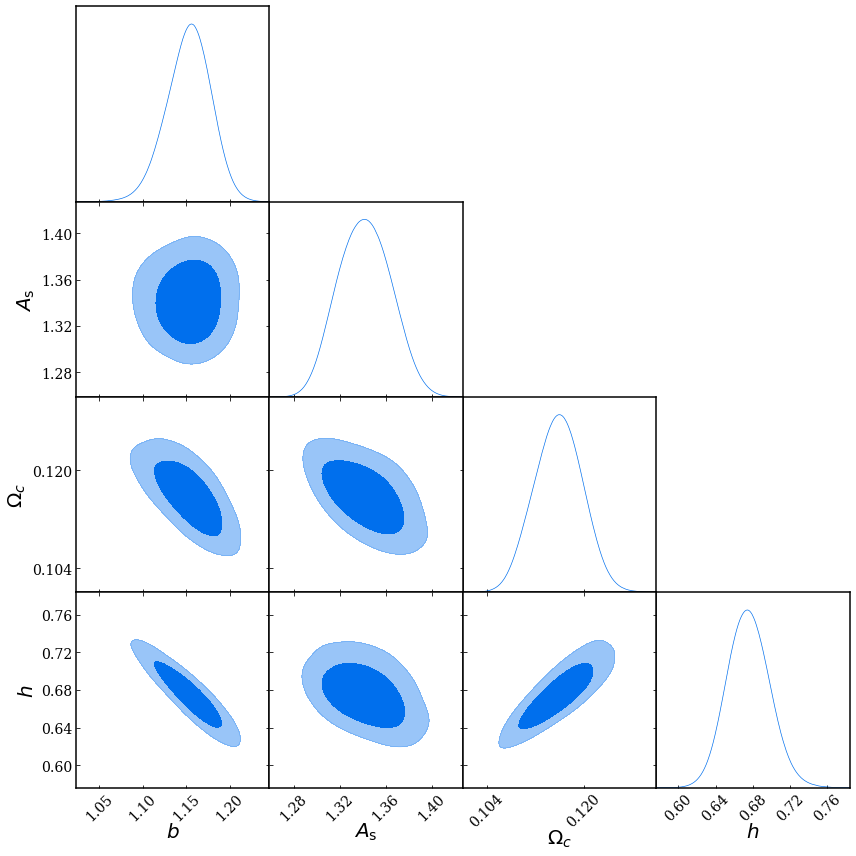

Population 5/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 270 samples, validate on 30 samples
Epoch 1/100
270/270 [==============================] - 0s 746us/step - loss: 1.7185 - val_loss: 2.2786
Epoch 2/100
270/270 [==============================] - 0s 772us/step - loss: 1.7681 - val_loss: 2.3415
Epoch 3/100
270/270 [==============================] - 0s 773us/step - loss: 1.6687 - val_loss: 2.4284
Epoch 4/100
270/270 [==============================] - 0s 781us/step - loss: 1.6527 - val_loss: 2.2815
Epoch 5/100
270/270 [==============================] - 0s 786us/step - loss: 1.6330 - val_loss: 2.3377
Epoch 6/100
270/270 [==============================] - 0s 767us/step - loss: 1.6233 - val_loss: 2.4576
Epoch 7/100
270/270 [==============================] - 0s 790us/step - loss: 1.6772 - val_loss: 2.3892
Epoch 8/100
270/270 [==============================] - 0s 786us/step - loss: 1.6461 - val_loss: 2.5209
Epoch 9/100
270/270 [==============================] - 0

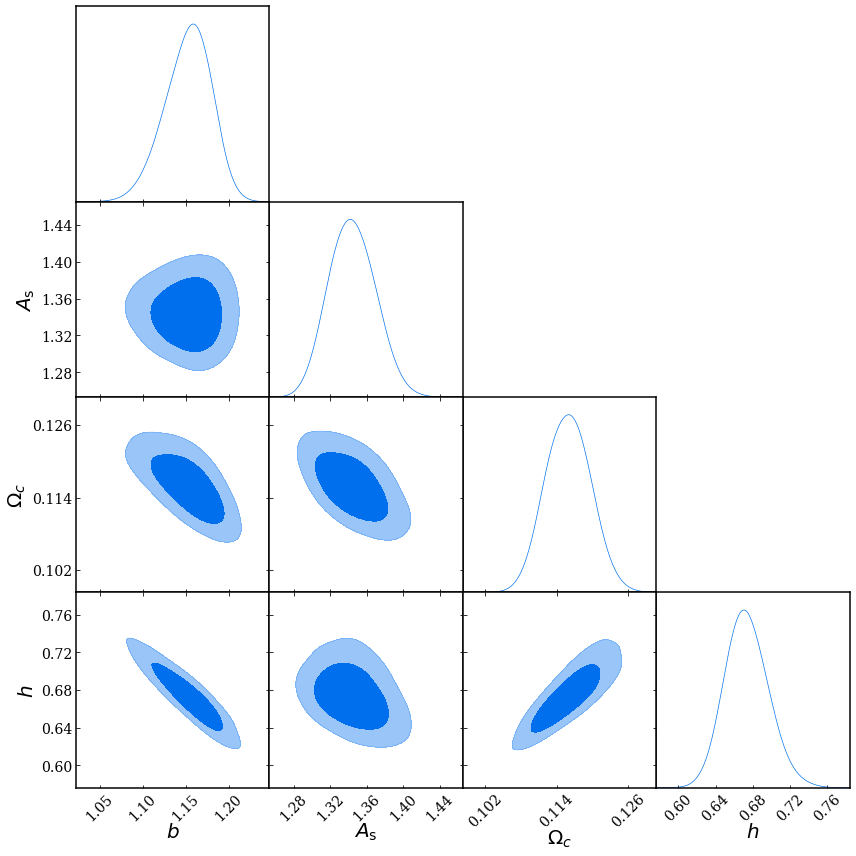

Population 6/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 315 samples, validate on 35 samples
Epoch 1/100
315/315 [==============================] - 0s 814us/step - loss: 1.6787 - val_loss: 2.2010
Epoch 2/100
315/315 [==============================] - 0s 771us/step - loss: 1.6619 - val_loss: 2.1126
Epoch 3/100
315/315 [==============================] - 0s 742us/step - loss: 1.7522 - val_loss: 2.3829
Epoch 4/100
315/315 [==============================] - 0s 795us/step - loss: 1.8365 - val_loss: 2.2667
Epoch 5/100
315/315 [==============================] - 0s 788us/step - loss: 1.8302 - val_loss: 2.0767
Epoch 6/100
315/315 [==============================] - 0s 773us/step - loss: 1.9785 - val_loss: 2.4358
Epoch 7/100
315/315 [==============================] - 0s 766us/step - loss: 2.3627 - val_loss: 2.2713
Epoch 8/100
315/315 [==============================] - 0s 797us/step - loss: 1.8666 - val_loss: 2.2065
Epoch 9/100
315/315 [==============================] - 0

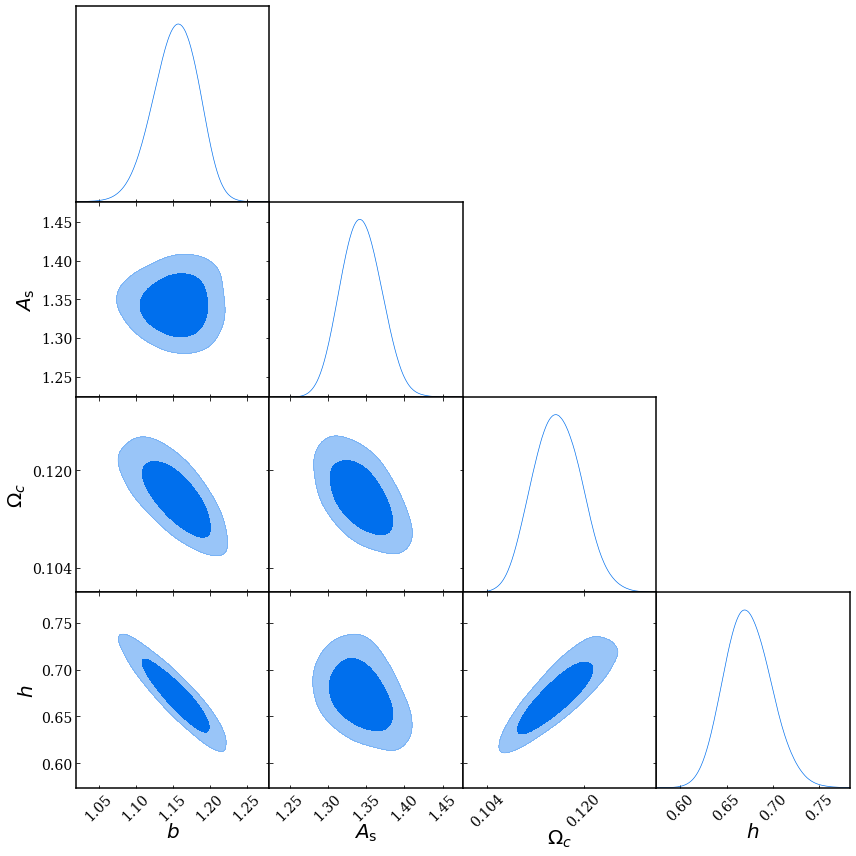

Population 7/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 360 samples, validate on 40 samples
Epoch 1/100
360/360 [==============================] - 1s 3ms/step - loss: 1.8245 - val_loss: 2.3771
Epoch 2/100
360/360 [==============================] - 0s 893us/step - loss: 1.7884 - val_loss: 2.4065
Epoch 3/100
360/360 [==============================] - 0s 793us/step - loss: 1.7696 - val_loss: 2.6522
Epoch 4/100
360/360 [==============================] - 0s 793us/step - loss: 1.7040 - val_loss: 2.5541
Epoch 5/100
360/360 [==============================] - 0s 790us/step - loss: 1.7368 - val_loss: 2.3556
Epoch 6/100
360/360 [==============================] - 0s 837us/step - loss: 1.7059 - val_loss: 2.5442
Epoch 7/100
360/360 [==============================] - 0s 836us/step - loss: 1.7342 - val_loss: 2.3604
Epoch 8/100
360/360 [==============================] - 0s 781us/step - loss: 1.7058 - val_loss: 2.3481
Epoch 9/100
360/360 [==============================] - 0s 

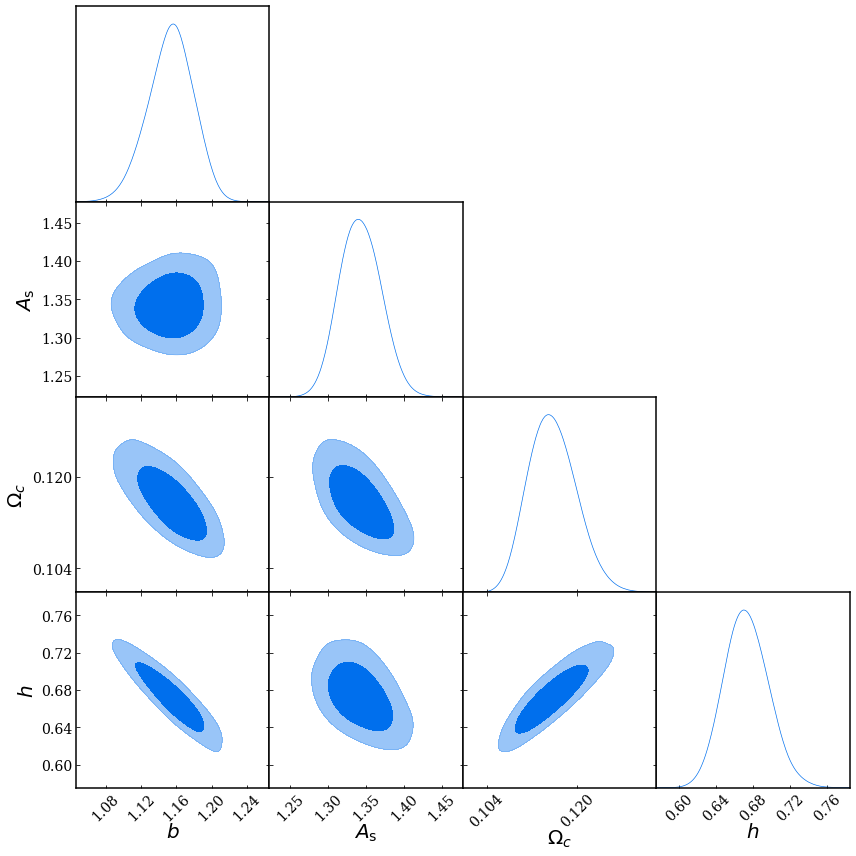

Population 8/8
Sampling proposal density...
Done.
Running 50 sims...
Done.
Train on 405 samples, validate on 45 samples
Epoch 1/100
405/405 [==============================] - 0s 861us/step - loss: 1.7443 - val_loss: 2.9756
Epoch 2/100
405/405 [==============================] - 0s 1ms/step - loss: 2.3010 - val_loss: 2.2142
Epoch 3/100
405/405 [==============================] - 0s 1ms/step - loss: 1.9372 - val_loss: 2.0627
Epoch 4/100
405/405 [==============================] - 0s 1ms/step - loss: 1.9514 - val_loss: 1.9786
Epoch 5/100
405/405 [==============================] - 0s 791us/step - loss: 1.9217 - val_loss: 2.2961
Epoch 6/100
405/405 [==============================] - 0s 866us/step - loss: 1.9403 - val_loss: 2.9583
Epoch 7/100
405/405 [==============================] - 0s 831us/step - loss: 2.7358 - val_loss: 2.5227
Epoch 8/100
405/405 [==============================] - 0s 807us/step - loss: 2.5602 - val_loss: 2.3802
Epoch 9/100
405/405 [==============================] - 0s 910u

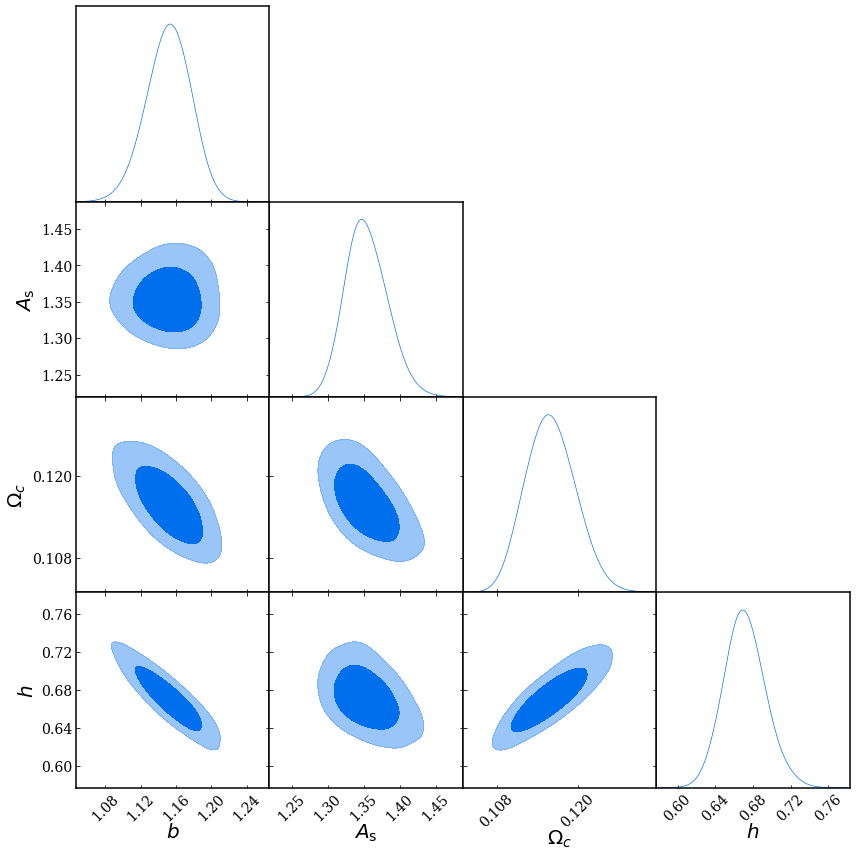

Final round of training with larger SGD batch size...
Train on 405 samples, validate on 45 samples
Epoch 1/300
405/405 [==============================] - 0s 747us/step - loss: 1.8981 - val_loss: 2.1144
Epoch 2/300
405/405 [==============================] - 0s 705us/step - loss: 2.0460 - val_loss: 2.2189
Epoch 3/300
405/405 [==============================] - 0s 743us/step - loss: 2.0438 - val_loss: 2.1692
Epoch 4/300
405/405 [==============================] - 0s 778us/step - loss: 1.9199 - val_loss: 2.0916
Epoch 5/300
405/405 [==============================] - 0s 723us/step - loss: 1.8192 - val_loss: 2.0735
Epoch 6/300
405/405 [==============================] - 0s 713us/step - loss: 1.8204 - val_loss: 2.0770
Epoch 7/300
405/405 [==============================] - 0s 783us/step - loss: 1.8681 - val_loss: 2.0263
Epoch 8/300
405/405 [==============================] - 0s 726us/step - loss: 1.8688 - val_loss: 1.9259
Epoch 9/300
405/405 [==============================] - 0s 704us/step - loss: 

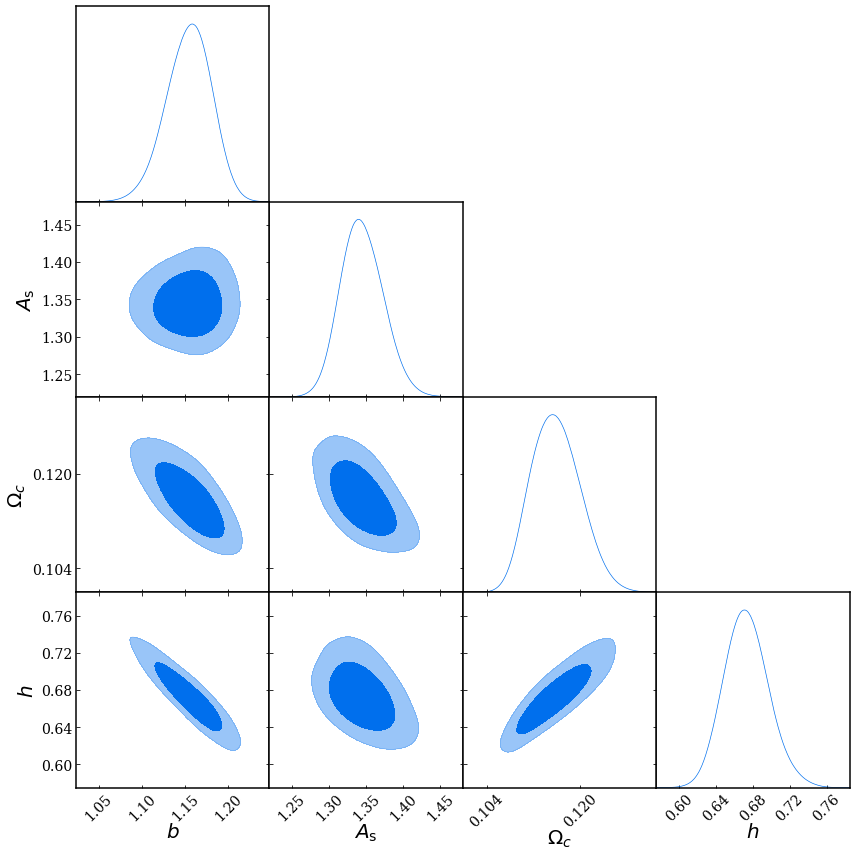

In [125]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*f_mat_inv, lower, upper)

# Initial samples, batch size for population samples, number of populations
#n_initial = 500
#n_batch = 500
n_initial = 50
n_batch = 50
n_populations = 8

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

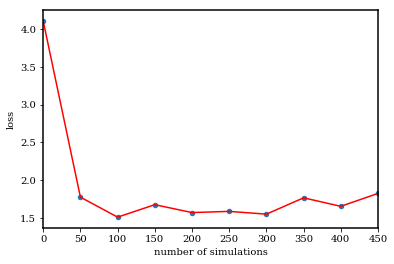

In [126]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()